In [1]:
# matplotlib cyberpunk style

!pip -q --disable-pip-version-check install mplcyberpunk

In [2]:
import os
import gc
import numpy as np
import pandas as pd

import shap
import random
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split

# 그래프 그리기
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import mplcyberpunk
plt.style.use('cyberpunk')
sns.set(rc = {'axes.facecolor': '#212946', 'figure.facecolor': '#ffffff'})

import warnings
warnings.filterwarnings('ignore')

In [3]:
%%time
df = pd.read_parquet('../input/ubiquant-parquet/train_low_mem.parquet')

CPU times: user 9.31 s, sys: 16.8 s, total: 26.1 s
Wall time: 39.9 s


In [4]:
X = df.drop(['row_id', 'time_id', 'target'], axis = 1)
y = df['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, shuffle = False, random_state = 10)

del df, X, y
gc.collect()

7233

In [5]:
model = LGBMRegressor(num_leaves = 6,
                     learning_rate = 0.05,
                     n_estimators = 1000,
                     min_child_samples = 1000,
                     subsample = 0.5,
                     metric = 'rmse'
                    )

In [6]:
model.fit(X_train, y_train, early_stopping_rounds = 6, eval_set =[(X_val, y_val)], verbose = 10)

[10]	valid_0's rmse: 0.902019
[20]	valid_0's rmse: 0.900828
[30]	valid_0's rmse: 0.900096
[40]	valid_0's rmse: 0.899532
[50]	valid_0's rmse: 0.899259
[60]	valid_0's rmse: 0.898985
[70]	valid_0's rmse: 0.898753
[80]	valid_0's rmse: 0.898595
[90]	valid_0's rmse: 0.898454
[100]	valid_0's rmse: 0.898358
[110]	valid_0's rmse: 0.898211
[120]	valid_0's rmse: 0.898162
[130]	valid_0's rmse: 0.898085
[140]	valid_0's rmse: 0.898025
[150]	valid_0's rmse: 0.89799
[160]	valid_0's rmse: 0.897885
[170]	valid_0's rmse: 0.89781
[180]	valid_0's rmse: 0.897745
[190]	valid_0's rmse: 0.897709
[200]	valid_0's rmse: 0.897648
[210]	valid_0's rmse: 0.897619
[220]	valid_0's rmse: 0.897568
[230]	valid_0's rmse: 0.897498


LGBMRegressor(learning_rate=0.05, metric='rmse', min_child_samples=1000,
              n_estimators=1000, num_leaves=6, subsample=0.5)

### SHAP(SHapley Additive exPlanations)
> Shap values are floating-point numbers corresponding to data in each row corresponding to each feature. Shap value represents the contribution of that particular data point in predicting the outputs. If the shap value is much closer to zero, we can say that the data point contributes very little to predictions. If the shap value is a strong positive or strong negative value, we can say that the data point greatly contributes to predictions.

In [7]:
# Initialize object that can calculate shap values
explainer = shap.TreeExplainer(model)

# Calculate Shap values
shap_values = explainer.shap_values(X_val)

> We will visualize summary plot to get the idea which feature mattered the most to the model

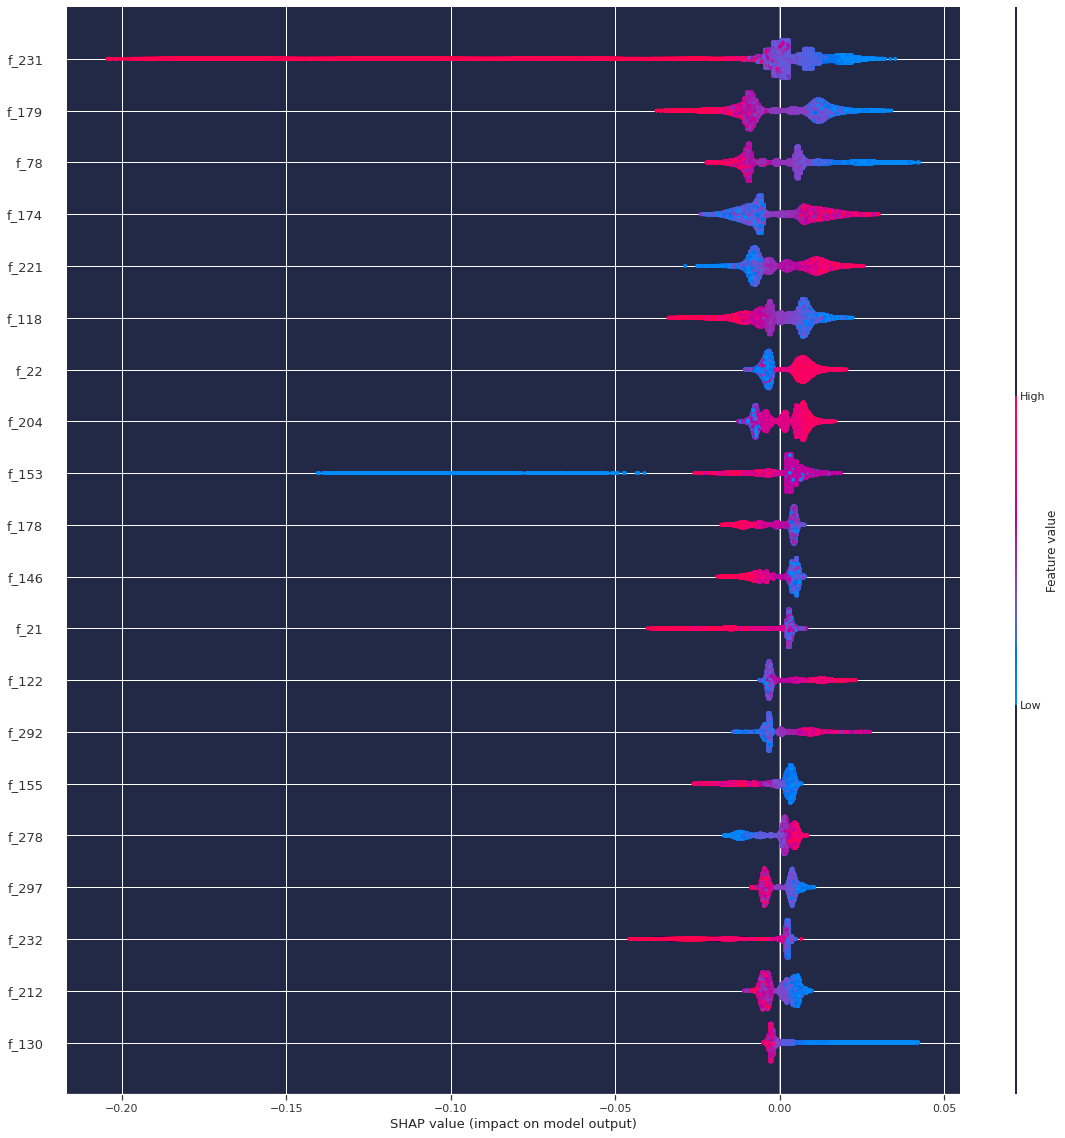

In [8]:
shap.summary_plot(shap_values, X_val, plot_size = (20, 20))

> `Note to study summary plot`: Horizontal location shows whether the effect of that value caused a higher or lower prediction and color shows whether that feature was high or low for that row of the dataset

> We can also plot a simple summary bar plot by giving argument `plot_type = bar`

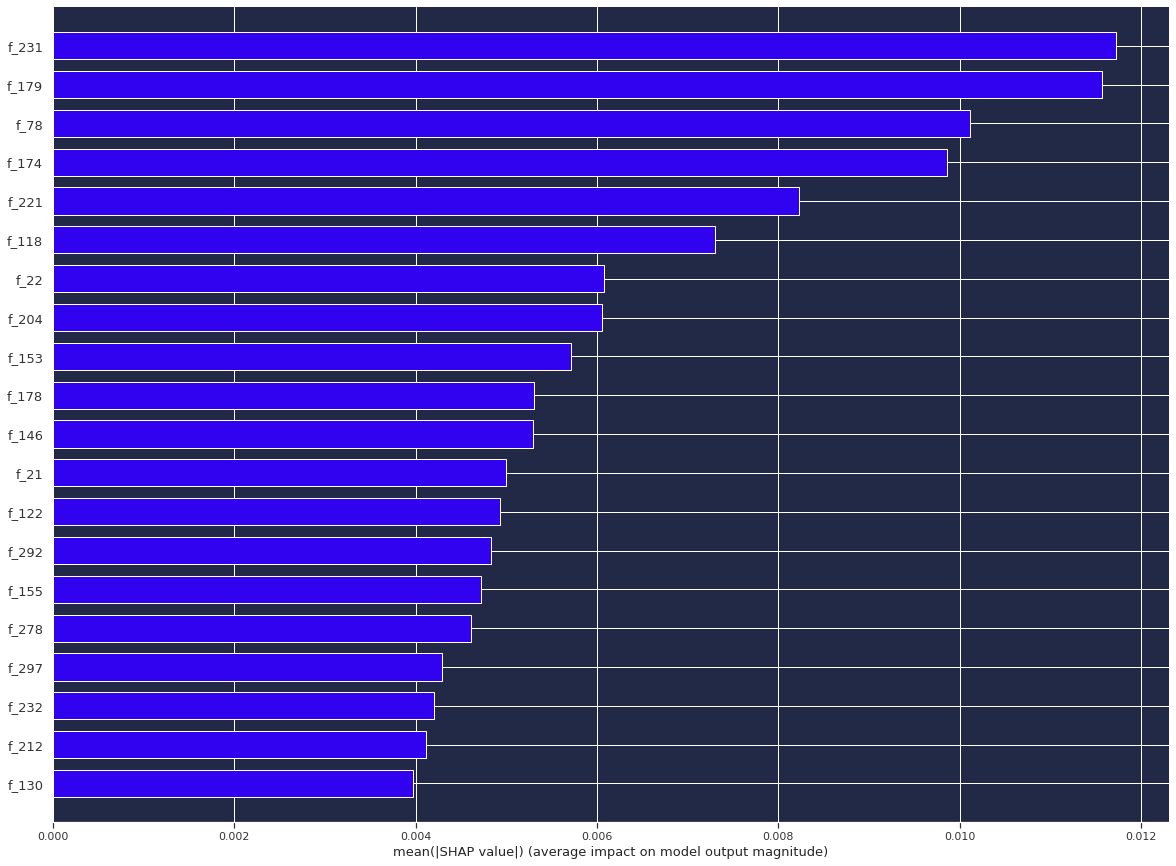

In [9]:
shap.summary_plot(shap_values, X_val, plot_type = 'bar', plot_size = (20, 15), color = '#3002f0')

> Lastly, we will look into dependence plot. Dependence plots can be of great use while analyzing feature importance and feature selection. It plots shap values of the desired feature and colorize the dot with respect to another feature. Here I will plot dependence plot of first 9 features.

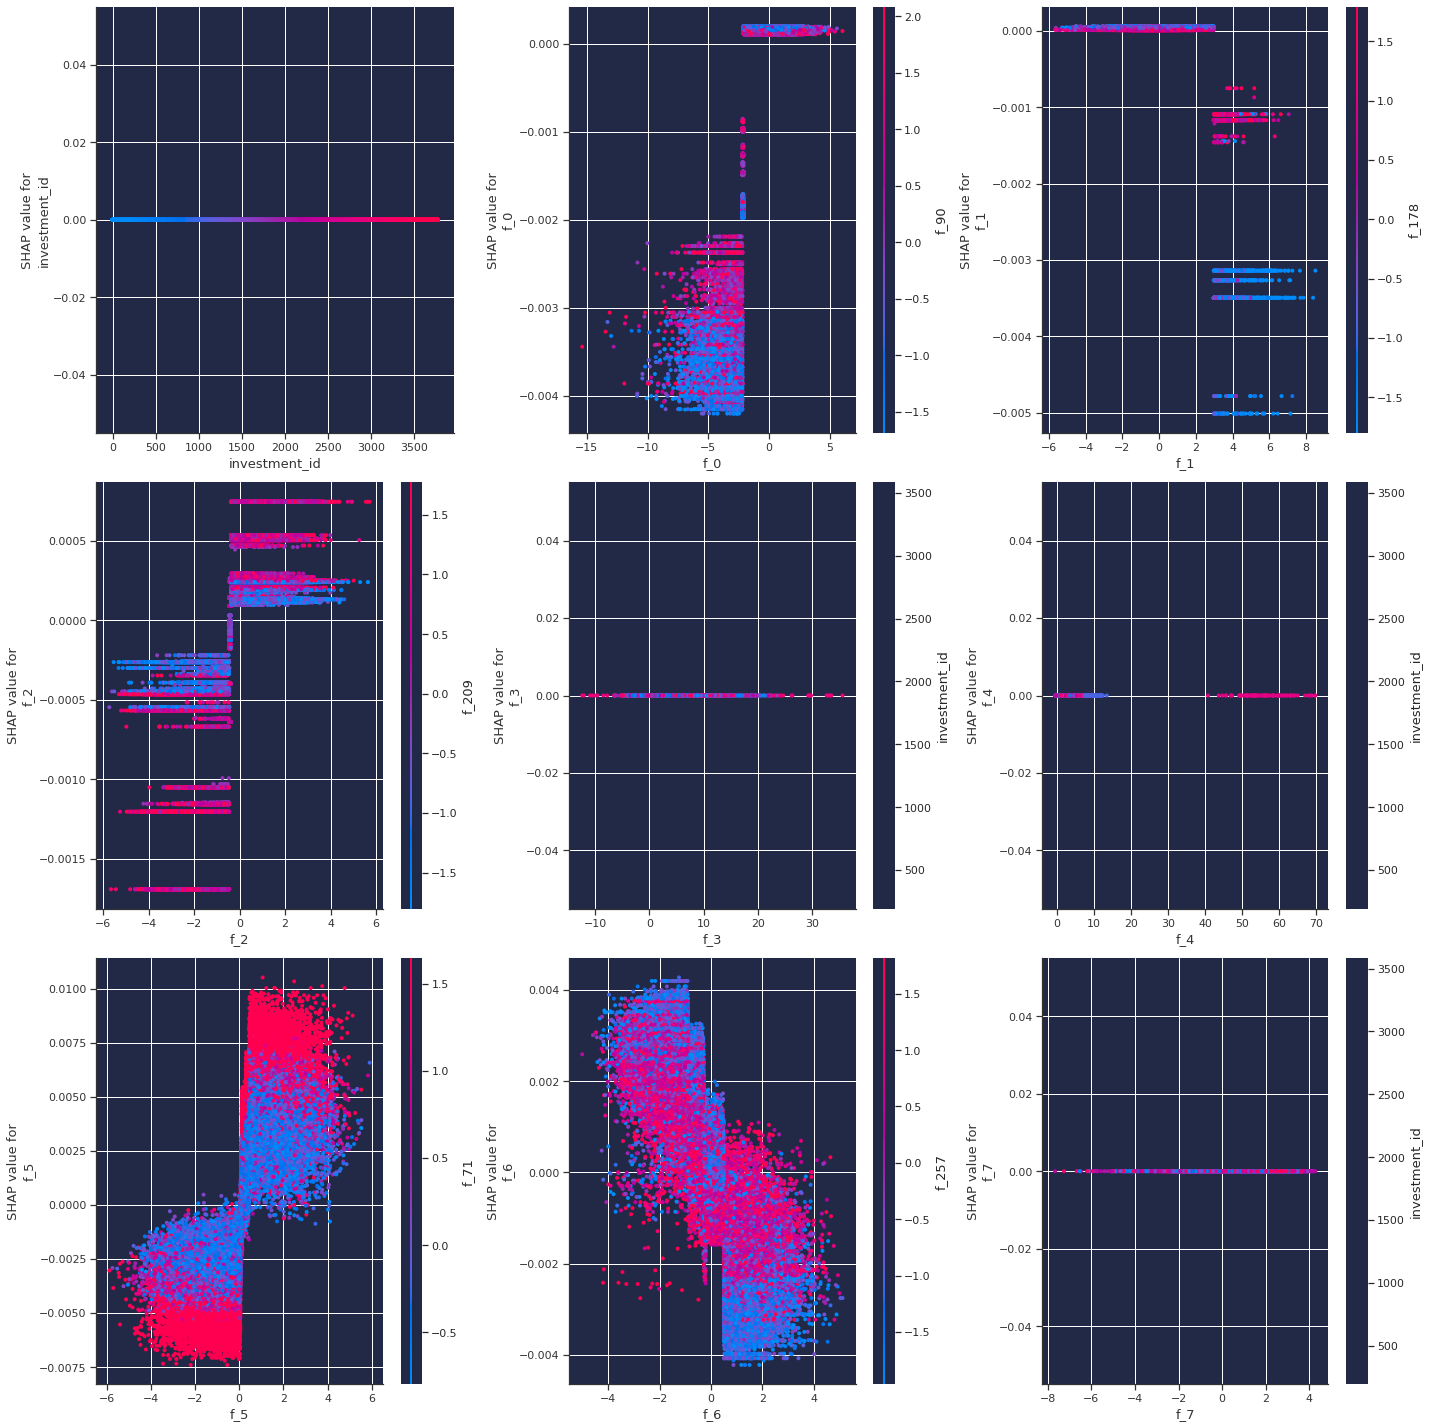

In [10]:
fig, ax = plt.subplots(3, 3, figsize = (20, 20))
ax = ax.ravel()

for i, x in enumerate(X_val.columns):
    shap.dependence_plot(x, shap_values, X_val, ax = ax[i], show = False)
    if i == 8:
        break
            
plt.tight_layout()
plt.show()

# SUBMISSION

In [11]:
import ubiquant

env = ubiquant.make_env()
iter_test = env.iter_test()

for (test_df, sample_prediction_df) in iter_test:
    test_df.drop(['row_id'], axis = 1, inplace = True)
    pred = model.predict(test_df)
    sample_prediction_df['target'] = pred
    env.predict(sample_prediction_df)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
